In [1]:
!pip install pyspark==3.2
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col# Initialize Spark session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 12.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805894 sha256=218a0c2692bf094e27e8e7618cdbeee4fcb1fd5f7e79e2f4166dab935b41c88a
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col

# Initialize a Spark session
spark = SparkSession.builder.appName("CrimeDataAnalysis").getOrCreate()

# Define paths to your local CSV files
crime_files_path = '/kaggle/input/part-a-crimedataset/*.csv'

# Load the crime dataset for all months and counties
crime_data = spark.read.csv(crime_files_path, header=True, inferSchema=True)

# Standardize the "Reported by" column by creating a new "County" column
crime_data_standardized = crime_data.withColumn(
    "County", regexp_replace(col("Reported by"), "Derbyshire Constabulary", "Derbyshire")
).withColumn(
    "County", regexp_replace(col("County"), "Leicestershire Police", "Leicestershire")
).withColumn(
    "County", regexp_replace(col("County"), "Kent Police", "Kent")
)

# Show a sample of the loaded and standardized data
crime_data_standardized.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/26 14:02:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|            Crime ID|  Month|Reported by|Falls within|Longitude| Latitude|            Location|LSOA code|   LSOA name|          Crime type|Last outcome category|Context|County|
+--------------------+-------+-----------+------------+---------+---------+--------------------+---------+------------+--------------------+---------------------+-------+------+
|b93c5583a3adce8a0...|2022-08|Kent Police| Kent Police| 0.973355|51.260972|On or near Lower ...|E01023987|Ashford 001B|            Burglary| Investigation com...|   null|  Kent|
|330e17b2dc5af6854...|2022-08|Kent Police| Kent Police| 0.963316|51.258906|On or near New Fo...|E01023987|Ashford 001B|Criminal damage a...| Investigation com...|   null|  Kent|
|794686e451d00c2c8...|2022-08|Kent Police| Kent Police| 0.958126|51.259568|On or near New Fo...|E01023987|Ashf

In [3]:
# Register the DataFrame as a SQL temporary view
crime_data_standardized.createOrReplaceTempView("crime_data")

# Query to calculate total crimes by county
total_crimes_by_county = spark.sql("""
    SELECT County, COUNT(*) as Total_Crimes
    FROM crime_data
    GROUP BY County
""")
total_crimes_by_county.show()

+--------------+------------+
|        County|Total_Crimes|
+--------------+------------+
|          Kent|      200945|
|Leicestershire|      115179|
|    Derbyshire|      110805|
+--------------+------------+



In [4]:
# Query to calculate total crimes per month for each county
monthly_crime_trends = spark.sql("""
    SELECT County, Month, COUNT(*) as Total_Crimes
    FROM crime_data
    GROUP BY County, Month
    ORDER BY County, Month
""")
monthly_crime_trends.show()



+----------+-------+------------+
|    County|  Month|Total_Crimes|
+----------+-------+------------+
|Derbyshire|2022-01|        8991|
|Derbyshire|2022-02|        8452|
|Derbyshire|2022-03|        9598|
|Derbyshire|2022-04|        9409|
|Derbyshire|2022-05|       10140|
|Derbyshire|2022-06|        9710|
|Derbyshire|2022-07|       10017|
|Derbyshire|2022-08|        9571|
|Derbyshire|2022-09|        8781|
|Derbyshire|2022-10|        9205|
|Derbyshire|2022-11|        8923|
|Derbyshire|2022-12|        8008|
|      Kent|2022-01|       16338|
|      Kent|2022-02|       15383|
|      Kent|2022-03|       17310|
|      Kent|2022-04|       17144|
|      Kent|2022-05|       17546|
|      Kent|2022-06|       17388|
|      Kent|2022-07|       17950|
|      Kent|2022-08|       18365|
+----------+-------+------------+
only showing top 20 rows



In [5]:
# Query to find the month with the highest and lowest number of crimes for each county
highest_lowest_crimes = spark.sql("""
    SELECT County, Month, Total_Crimes FROM (
        SELECT County, Month, COUNT(*) as Total_Crimes,
               RANK() OVER (PARTITION BY County ORDER BY COUNT(*) DESC) as rank_high,
               RANK() OVER (PARTITION BY County ORDER BY COUNT(*) ASC) as rank_low
        FROM crime_data
        GROUP BY County, Month
    ) WHERE rank_high = 1 OR rank_low = 1
""")
highest_lowest_crimes.show()

+--------------+-------+------------+
|        County|  Month|Total_Crimes|
+--------------+-------+------------+
|    Derbyshire|2022-12|        8008|
|    Derbyshire|2022-05|       10140|
|          Kent|2022-12|       14976|
|          Kent|2022-08|       18365|
|Leicestershire|2022-02|        8482|
|Leicestershire|2022-08|       10373|
+--------------+-------+------------+



In [6]:
# Rename the "Crime type" column to "Crime_Type"
crime_data_standardized = crime_data_standardized.withColumnRenamed("Crime type", "Crime_Type")

# Register the DataFrame as a SQL temporary view again
crime_data_standardized.createOrReplaceTempView("crime_data")

# Query to calculate most and least common crime types in each county
crime_type_analysis = spark.sql("""
    SELECT County, Crime_Type, COUNT(*) as Crime_Count
    FROM crime_data
    GROUP BY County, Crime_Type
    ORDER BY County, Crime_Count DESC
""")
crime_type_analysis.show()



+----------+--------------------+-----------+
|    County|          Crime_Type|Crime_Count|
+----------+--------------------+-----------+
|Derbyshire|Violence and sexu...|      41878|
|Derbyshire|Anti-social behav...|      23038|
|Derbyshire|        Public order|      10198|
|Derbyshire|Criminal damage a...|       8724|
|Derbyshire|         Other theft|       6821|
|Derbyshire|       Vehicle crime|       4669|
|Derbyshire|         Shoplifting|       4237|
|Derbyshire|            Burglary|       3806|
|Derbyshire|               Drugs|       2292|
|Derbyshire|         Other crime|       2053|
|Derbyshire|Possession of wea...|        949|
|Derbyshire|             Robbery|        769|
|Derbyshire|Theft from the pe...|        767|
|Derbyshire|       Bicycle theft|        604|
|      Kent|Violence and sexu...|      83341|
|      Kent|Anti-social behav...|      27904|
|      Kent|Criminal damage a...|      19936|
|      Kent|         Other theft|      14318|
|      Kent|        Public order| 

In [7]:
# Query to find the most and least common crime types for each county
most_least_common_crime = spark.sql("""
    SELECT County, Crime_Type, Crime_Count FROM (
        SELECT County, Crime_Type, COUNT(*) as Crime_Count,
               RANK() OVER (PARTITION BY County ORDER BY COUNT(*) DESC) as rank_high,
               RANK() OVER (PARTITION BY County ORDER BY COUNT(*) ASC) as rank_low
        FROM crime_data
        GROUP BY County, Crime_Type
    ) WHERE rank_high = 1 OR rank_low = 1
""")
most_least_common_crime.show()

+--------------+--------------------+-----------+
|        County|          Crime_Type|Crime_Count|
+--------------+--------------------+-----------+
|    Derbyshire|       Bicycle theft|        604|
|    Derbyshire|Violence and sexu...|      41878|
|          Kent|Theft from the pe...|       1007|
|          Kent|Violence and sexu...|      83341|
|Leicestershire|             Robbery|        811|
|Leicestershire|Violence and sexu...|      44019|
+--------------+--------------------+-----------+



In [8]:
!pip install matplotlib seaborn

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

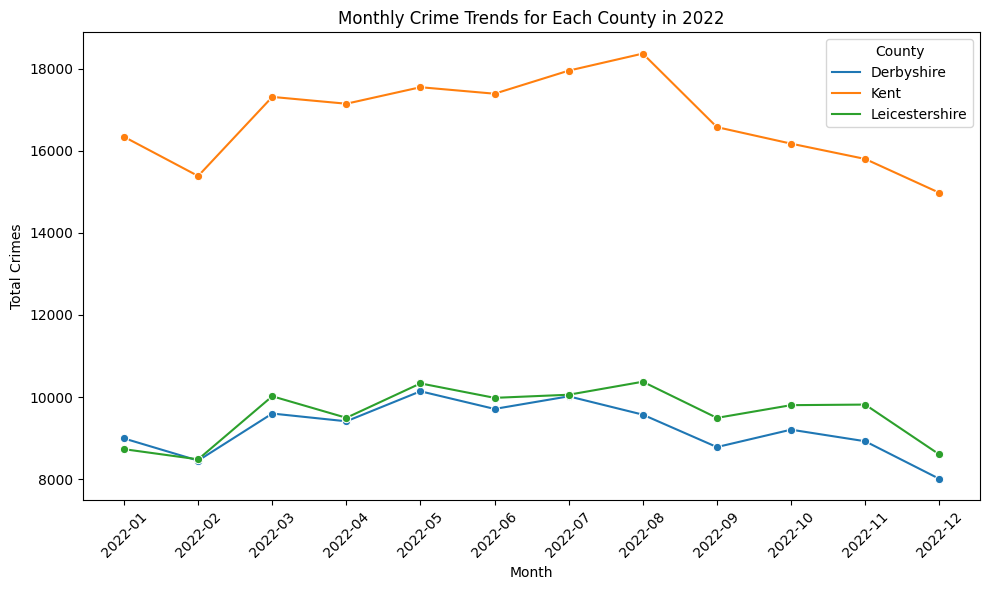

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas for visualization
monthly_crime_trends_df = monthly_crime_trends.toPandas()

# Create a line plot for monthly crime trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_crime_trends_df, x="Month", y="Total_Crimes", hue="County", marker="o")
plt.title("Monthly Crime Trends for Each County in 2022")
plt.xlabel("Month")
plt.ylabel("Total Crimes")
plt.legend(title="County")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

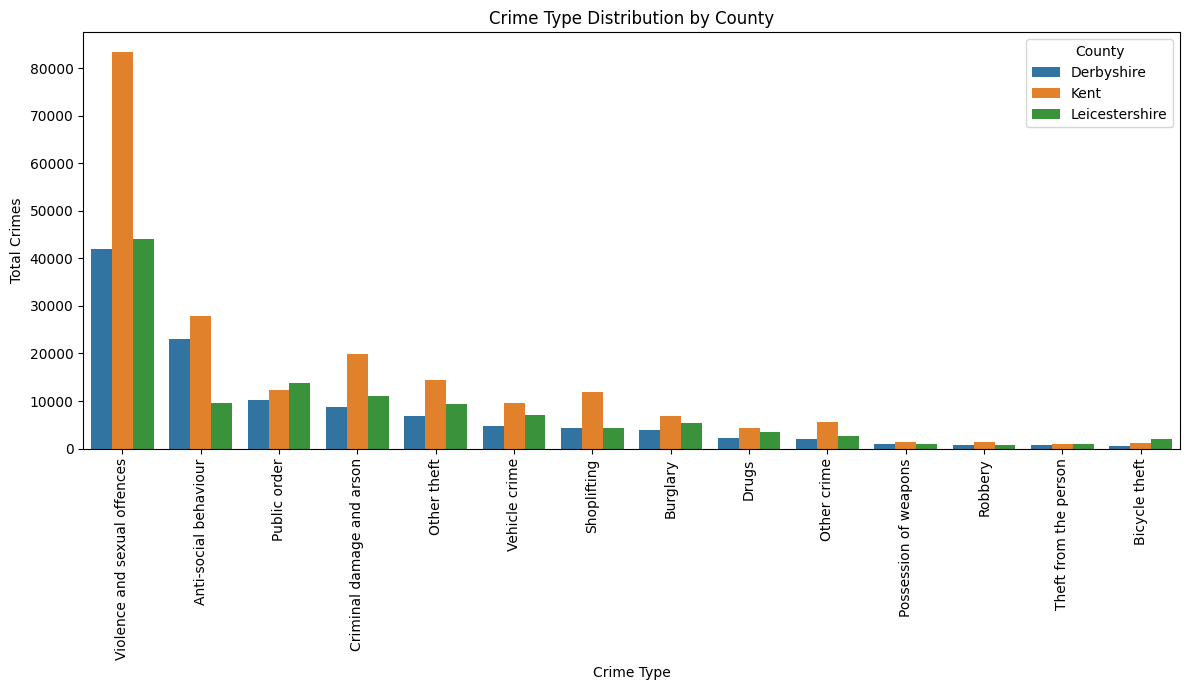

In [10]:
# Convert the crime type analysis to a Pandas DataFrame for plotting
crime_type_analysis_df = crime_type_analysis.toPandas()

# Create a bar chart comparing the total number of each crime type for each county
plt.figure(figsize=(12, 7))
sns.barplot(data=crime_type_analysis_df, x="Crime_Type", y="Crime_Count", hue="County")
plt.title("Crime Type Distribution by County")
plt.xlabel("Crime Type")
plt.ylabel("Total Crimes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

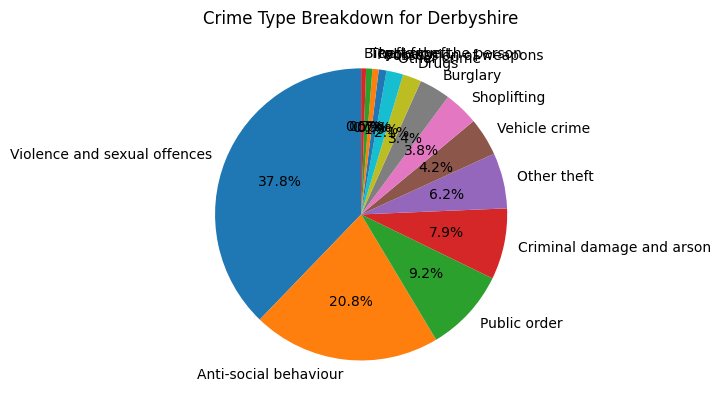

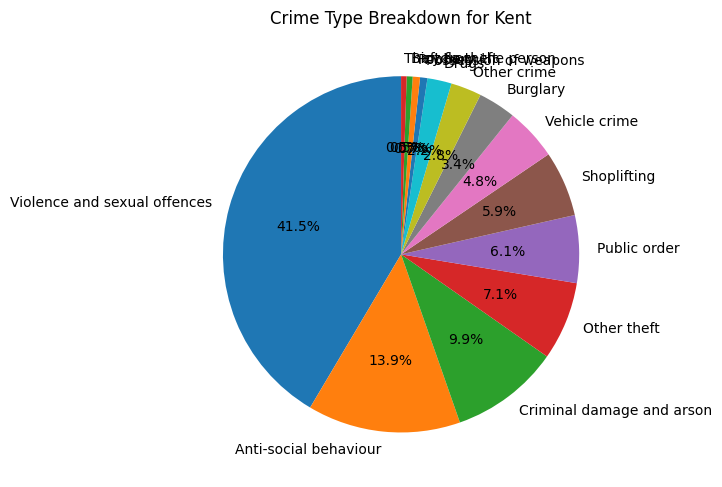

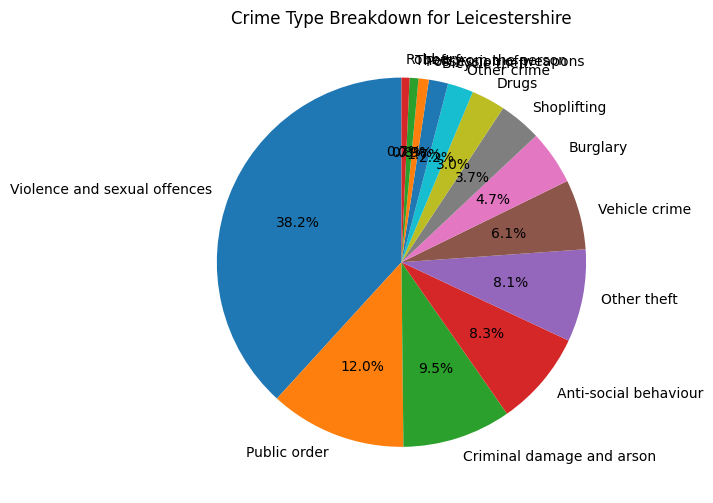

In [11]:
# Function to create pie charts for each county
def create_pie_chart(df, county):
    county_data = df[df['County'] == county]
    plt.figure(figsize=(7, 7))
    plt.pie(county_data['Crime_Count'], labels=county_data['Crime_Type'], autopct='%1.1f%%', startangle=90)
    plt.title(f"Crime Type Breakdown for {county}")
    plt.tight_layout()
    plt.show()

# Separate data for each county and create pie charts
for county in crime_type_analysis_df['County'].unique():
    create_pie_chart(crime_type_analysis_df, county)